# gpsMSSA
##Test ability of mssa to gind transients in time series

Based on:

[Walwer, Damian, Eric Calais, and Michael Ghil. "Data‐Adaptive Detection of Transient Deformation in Geodetic Networks." Journal of Geophysical Research: Solid Earth (2016).](http://onlinelibrary.wiley.com/doi/10.1002/2015JB012424/pdf)

We will start with synthetic data using a SSE like transient with random noise:

First we create a series of transients (10) with the same transient and random noise...


In [181]:
#import relevent libraries
import numpy as np
import pandas as pd
from gpsMSSA import ssa,syn_data,mssa,gpsUtils
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [307]:
def make_syn_df(times,funlist,numChannels):
    '''
    generate synthetic time series
    '''
    x = syn_data.model_tseries(times,funlist)
    columns = ['C'+str(i) for i in range(numChannels)]
    data = np.zeros((len(times),numChannels))
    for i in range(numChannels):
        #noise = np.random.normal(0,1,len(times))
        data[:,i] = x #np.add(x,noise)
    df = pd.DataFrame(data,index=times,columns=columns)
    return df

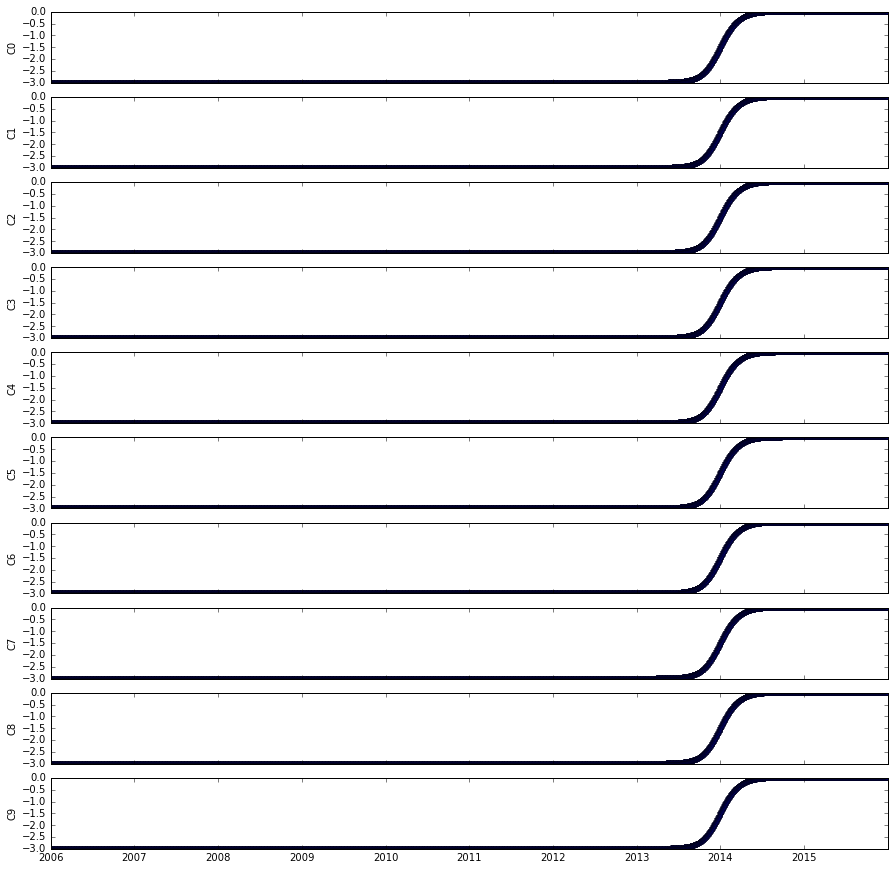

In [308]:
#time series from 2012 to 2016
times = np.arange(2006,2016,(1/365.25))

fun = 'syn_data.sse' #arctan function
args = [0,2014.0,80.0,3.0] #sse has a midpoint of 2014.0, a duration of 40 days and amplitude of 3
funList = []
funList.append(eval(fun)(*args))
df = make_syn_df(times,funList,10) #10 is the number of channels
f, ax = plt.subplots(len(df.columns), sharex=True, sharey=True,figsize=(15,15) )
for i,c in enumerate(df.columns):
    ax[i].plot([gpsUtils.decimal2datetime(d) for d in times],df[c],'*')
    ax[i].set_ylabel(df.columns[i])

So now we have 10 channels of data, with random noise (gaussian with std = 1.0 added to the signal. 
First we have to create the lagged covariance matrix c. 

We also have to set the lag time window M. In this case we will use a lag time window of 400 days. 


In [309]:
M = 400
c = mssa.toep_cov(df,M)

(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)


Next we get the eigenvectors and eigenvalues from the Lagged covariance matrix

In [310]:
len(df)

3653

In [314]:
rho,lamb = mssa.get_eigen(c)


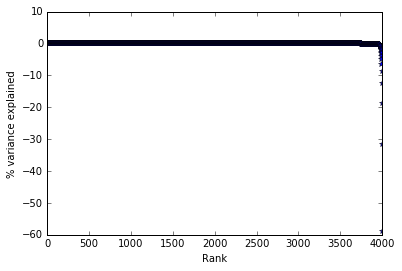

In [317]:
plot(lamb[1:-1],'*')
#xlim(-1,31)
xlabel('Rank')
#yscale('log')
ylabel('% variance explained')
#len(lamb)

In [318]:
lamb[0]
lamb[-1]

-172.49337740921089

We can see that almost all the variance is explained by the first eigenvalue.

Next lets look at the Principal components

In [319]:
pc = mssa.get_PC(rho,M,df)

Lets plot the first 3 principal components:

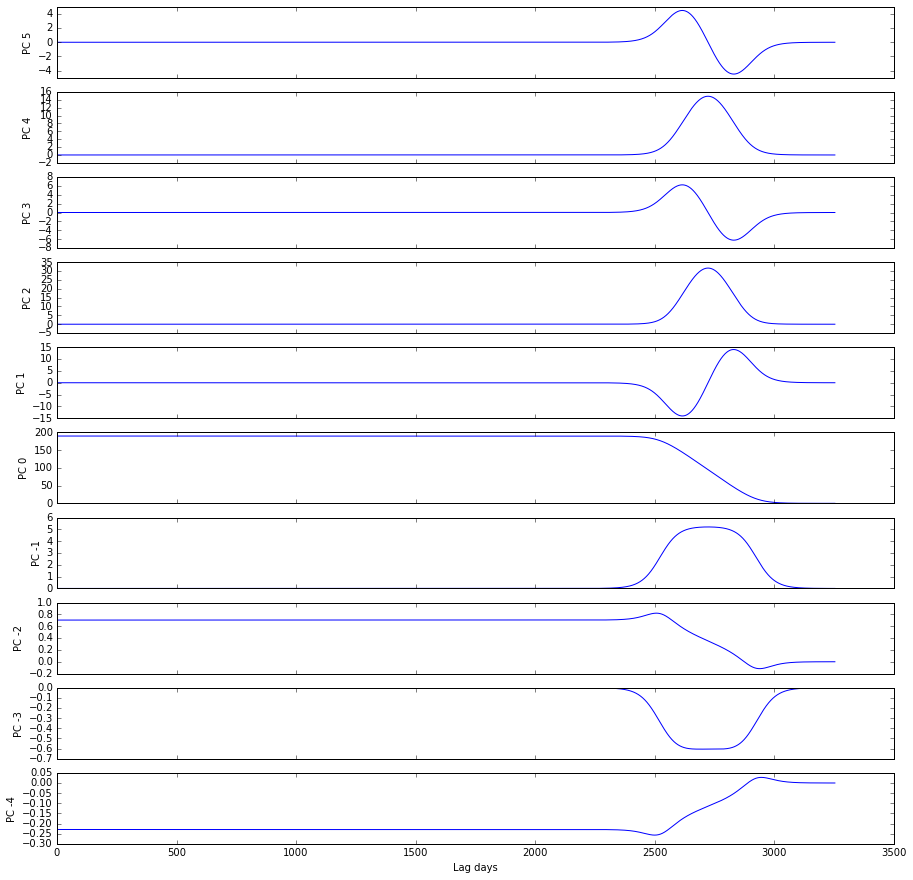

In [320]:
fig,ax = plt.subplots(10, sharex=True,figsize=(15,15) )
for r,i in enumerate(range(5,-5,-1)):
    ax[r].plot(pc[:,i])
    ax[r].set_ylabel('PC ' + str(i))
ax[r].set_xlabel('Lag days')


In [280]:
len(df)

1461

So we can see, as expected by the eigenvalues that the first component contains most of the signal. 

However, this is in terms of lag and the amplitude is meaningless, lets reproject back onto the original time series. 

In [322]:
# R is reconstructed components, RS is summed reconstruction
R,RS = mssa.rc(rho,pc,len(df.columns))

First, lets look at the first channel raw data and see if the summed RC receate the data. 


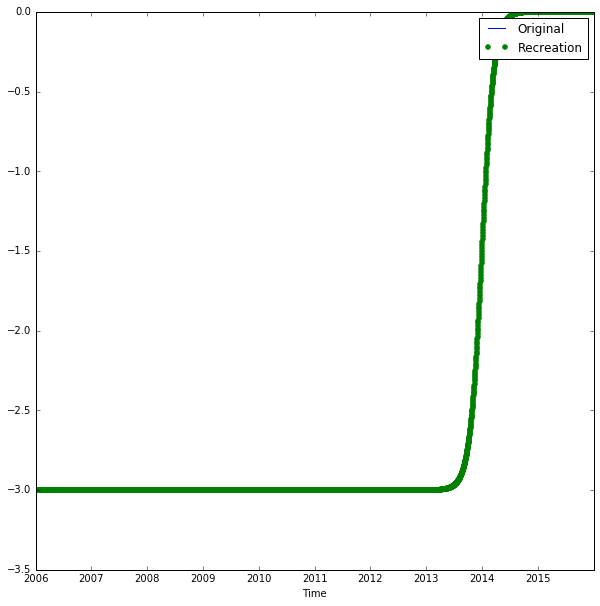

In [323]:
t = [gpsUtils.decimal2datetime(d) for d in times]
plot(t,df[df.columns[0]],label ='Original')
plot(t,RS[:,0],'.',markersize = 10 ,label = 'Recreation')
xlabel('Time')
legend()
f = gcf()
f.set_size_inches(10,10)

So using all the PC we can recreate the original data perfectly. Lets compare the 1st component with the raw data for every channel...

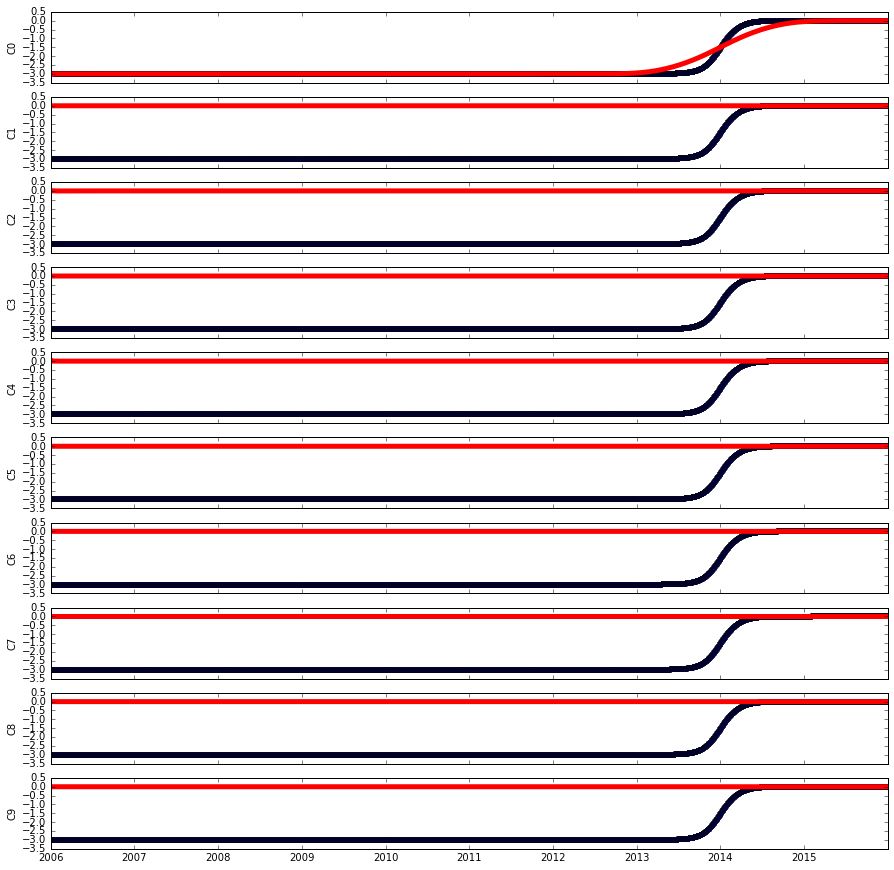

In [326]:
f, ax = plt.subplots(len(df.columns), sharex=True, sharey=True,figsize=(15,15) )
for i,c in enumerate(df.columns):
    ax[i].plot(t,df[c],'*')
    ax[i].set_ylabel(df.columns[i])
    ax[i].plot(t,R[:,i*-10],c = 'r',linewidth= 5)

In [359]:
idx = np.where(lamb>0)
np.shape(idx)

(1, 3314)

And we can compare the computed PC with the synthetic data...



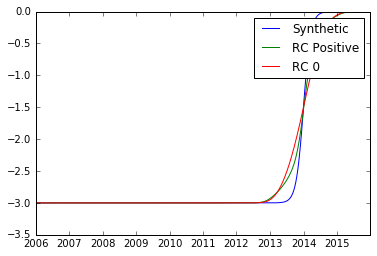

In [368]:
syn = syn_data.model_tseries(times,funList)
plot(t,syn,label = 'Synthetic')

r = np.zeros(len(R[:,0]))
for i in idx[0]:
    r  = r + R[:,(i*10)]
plot(t,r,label = 'RC Positive')
plot(t,R[:,0],label = 'RC 0 ')
legend()


In [349]:
r

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

So we can recreate the signal, but the lag time we used is exactly equal to the duration of the SSE which we dont know in real life. What happens when we use different lag times?


In [208]:
M10 = 10  #a ten day lag 
c10 = mssa.toep_cov(df,M10)
[rho10,lamb10] = mssa.get_eigen(c10)
pc10 = mssa.get_PC(rho10,M10,df)
R10,RS10 = mssa.rc(rho10,pc10,len(df.columns))

M4 = 400  #a four hundred day lag 
c4 = mssa.toep_cov(df,M4)
[rho4,lamb4] = mssa.get_eigen(c4)
pc4 = mssa.get_PC(rho4,M4,df)
R4,RS4 = mssa.rc(rho4,pc4,len(df.columns))


(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)


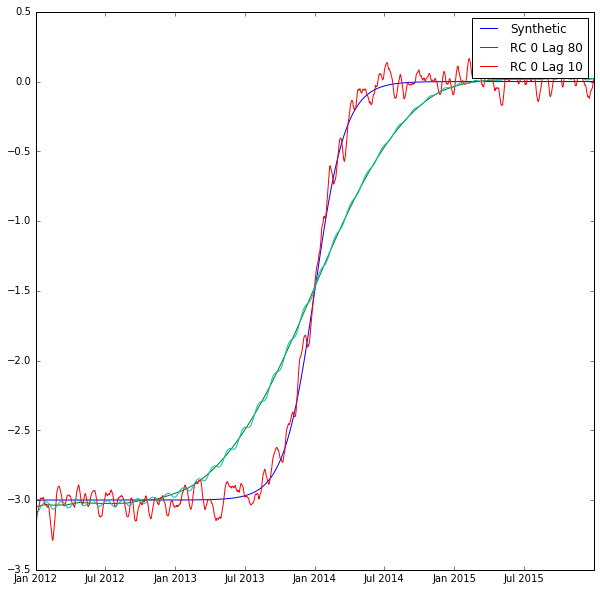

In [263]:
plot(t,syn,label = 'Synthetic')
plot(t,R[:,0],label = 'RC 0 Lag 80')
plot(t,R10[:,0],label = 'RC 0 Lag 10')
plot(t,R4[:,0]+R4[:,-1]+R4[:,-2])#]+R4[:,30]+R4[:,40],label = 'RC 0 Lag 400')
#plot(t,R4[:,0])
legend()
f = gcf()
f.set_size_inches(10,10)

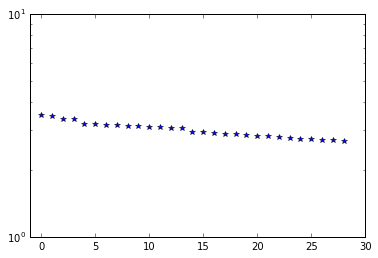

In [220]:
plt.plot(lamb4[1:30],'*')
xlim(-1,30)
yscale('log')

In [371]:
np.mean(lamb10)

2.1444547055441348